In [75]:
from collections import Counter
import os
import random
import string

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns
import torch
from transformers import AutoTokenizer
from wordcloud import STOPWORDS, WordCloud
%matplotlib inline
sns.set()
import warnings
import plotly
warnings.filterwarnings('ignore')

In [54]:
INPUT = "./input"
OUTPUT = "./output"
SEED = 0
train = pd.read_csv(os.path.join(INPUT, "train_data.csv"))
test = pd.read_csv(os.path.join(INPUT, "test_data.csv"))
train["is_train"] = 1
test["is_train"] = 0
all_data = pd.concat([train, test], ignore_index=True)

In [55]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [56]:
print(train.shape, test.shape)
print(train["contents"].nunique())
print(test["contents"].nunique())

(8878, 4) (24838, 3)
8675
22147


In [57]:
display(train.describe(include=[object]))
display(test.describe(include=[object]))

,contents
count,8878
unique,8675
top,Subject: calpine daily gas nomination\r\n>\r\n...
freq,13


,contents
count,24838
unique,22147
top,Subject: \r\n
freq,51


In [58]:
print("contentsが重複:", len(train[train.duplicated(subset=["contents"])]))
print("contentsとyがどちらも重複:", len(train[train.duplicated(subset=["contents", "y"])]))
train[train.duplicated(subset=["contents", "y"])]

contentsが重複: 203
contentsとyがどちらも重複: 203


,id,contents,y,is_train
624,625,Subject: calpine daily gas nomination\r\n>\r\n...,0,1
764,765,Subject: calpine daily gas nomination\r\n>\r\n...,0,1
855,856,Subject: fw : rahil jafry : carly fiorina tops...,0,1
865,866,Subject: enron japan weekly update\r\nhello ej...,0,1
994,995,Subject: attention : changes in remote access\...,0,1
...,...,...,...,...
8789,8790,Subject: entouch newsletter\r\nbusiness highli...,0,1
8840,8841,Subject: re : global risk management operation...,0,1
8869,8870,Subject: thanks for the offsite\r\nthank you f...,0,1
8872,8873,Subject: salary increase for logistics schedul...,0,1


In [59]:
display(train["contents"].value_counts()[:2])
train_value_counts = train["contents"].value_counts()
len(train_value_counts[train_value_counts>=2])

Subject: calpine daily gas nomination\r\n>\r\nricky a . archer\r\nfuel supply\r\n700 louisiana , suite 2700\r\nhouston , texas 77002\r\n713 - 830 - 8659 direct\r\n713 - 830 - 8722 fax\r\n- calpine daily gas nomination 1 . doc                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

185

In [60]:
print("contentsが重複:", len(test[test.duplicated(subset=["contents"])]))
test[test.duplicated(subset=["contents"])]

contentsが重複: 2691


,id,contents,is_train
596,597,Subject: re : ink prices got you down ? 11956\...,0
871,872,Subject: hi paliourg get all pills . everythin...,0
924,925,Subject: save your money buy getting this thin...,0
1129,1130,Subject: select small - cap for astute investo...,0
1173,1174,Subject: caiso notification - tswg conference ...,0
...,...,...,...
24817,24818,Subject: fulton bank online security message\r...,0
24818,24819,Subject: request for transfer assistance\r\nfr...,0
24827,24828,"Subject: freedom - $ 1 , 021 , 320 . 00 per ye...",0
24830,24831,Subject: delivery status notification ( failur...,0


In [61]:
display(test["contents"].value_counts()[:3])
test_value_counts = test["contents"].value_counts()
len(test_value_counts[test_value_counts>=2])

Subject: \r\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

2564

In [62]:
test[test["contents"].isin(train["contents"])]

,id,contents,is_train
0,1,Subject: re : weather and energy price data\r\...,0
43,44,Subject: ena analysts and associates\r\ni have...,0
239,240,Subject: board presentation - revised\r\nlouis...,0
523,524,Subject: overview of investor conference call\...,0
535,536,Subject: organization announcement\r\nenron pu...,0
...,...,...,...
24592,24593,Subject: gmm 21 sep 01\r\nplease find attached...,0
24626,24627,Subject: get debts off your back - time : 5 : ...,0
24683,24684,Subject: internet connectivity that beats the ...,0
24743,24744,Subject: enron mentions\r\nenron taps $ 3 bill...,0


In [63]:
display(all_data[all_data["contents"].str[0:9] != "Subject: "])
display(all_data[all_data["contents"].str.contains("/r/n")])

,id,contents,y,is_train


,id,contents,y,is_train


In [67]:
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
train['num_word'] = train['contents'].apply(lambda x:len(tokenizer.encode(x, truncation=False)))
test['num_word'] = test['contents'].apply(lambda x:len(tokenizer.encode(x, truncation=False)))
train.head()

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (659 > 512). Running this sequence through the model will result in indexing errors


,id,contents,y,is_train,num_word
0,1,Subject: re : fw : willis phillips\r\ni just s...,0,1,96
1,2,Subject: re : factor loadings for primary curv...,0,1,391
2,3,Subject: re : meridian phone for kate symes\r\...,0,1,98
3,4,"Subject: re : october wellhead\r\nvance ,\r\nd...",0,1,168
4,5,Subject: california 6 / 13\r\nexecutive summar...,0,1,659


In [68]:
print(f'longer than 512 (train): {len(train[train["num_word"]>512].index)} / {len(train.index)}')
print(f'longer than 512 (test): {len(test[test["num_word"]>512].index)} / {len(test.index)}')

longer than 512 (train): 1628 / 8878
longer than 512 (test): 4380 / 24838


In [77]:
train["word_list"] = train["contents"].apply(lambda x:tokenizer.tokenize(x))

In [79]:
top = Counter([item for sublist in train["word_list"] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ["Common_words", "count"]
temp.style.background_gradient(cmap="Blues")

,Common_words,count
0,-,161488
1,.,145953
2,",",118498
3,the,94052
4,:,69049
5,to,67404
6,/,66664
7,and,43695
8,of,40371
9,en,34759


In [84]:
nltk.download("stopwords")
stopwords_list = set(stopwords.words("english") + list(string.punctuation))
stopwords_list
def remove_stopword(x):
    return [y for y in x if y not in stopwords_list]
train["word_list"] = train["word_list"].apply(lambda x: remove_stopword(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [85]:
top = Counter([item for sublist in train["word_list"] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ["Common_words", "count"]
temp.style.background_gradient(cmap="Blues")

,Common_words,count
0,en,34759
1,##ron,32103
2,##t,21659
3,ec,18433
4,subject,15162
5,##s,13695
6,##u,11654
7,ho,8983
8,2001,8274
9,2000,7293


In [86]:
def words_unique(label, numwords, raw_words):
    '''
    Input:
        label - spam or not spam;
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list for item in train_df['word_list']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    all_other = set()
    for item in train[train.y != label]['word_list']:
        for word in set(item):
            all_other.add(word)
    
    unique_words = set([x for x in raw_text if x not in all_other])
    
    counter = Counter()
    
    for item in train[train.y == label]['word_list']:
        for word in item:
            counter[word] += 1
    
    for word in list(counter):
        if word not in unique_words:
            del counter[word]
    
    unique_words_df = pd.DataFrame(counter.most_common(numwords), columns = ['words','count'])
    
    return unique_words_df

In [87]:
raw_text = set([word for word_list in train["word_list"] for word in word_list])

In [89]:
unique_top_spam = words_unique(0, 20, raw_text)
print("The top 20 unique words in not spam:")
unique_top_spam.style.background_gradient(cmap="Greens")

The top 20 unique words in not spam:


,words,count
0,cc,4911
1,vince,4739
2,houston,3027
3,##yne,2875
4,##inski,2762
5,kam,2753
6,71,2232
7,mm,2010
8,john,1964
9,hp,1913


In [90]:
unique_spam = words_unique(1, 20, raw_text)
print("The top unique words in spam:")
unique_spam.style.background_gradient(cmap="Reds")

The top unique words in spam:


,words,count
0,ion,13
1,php,11
2,##sphere,10
3,penis,7
4,##cion,6
5,portraits,5
6,orgasm,5
7,##wear,5
8,pali,5
9,bbc,5


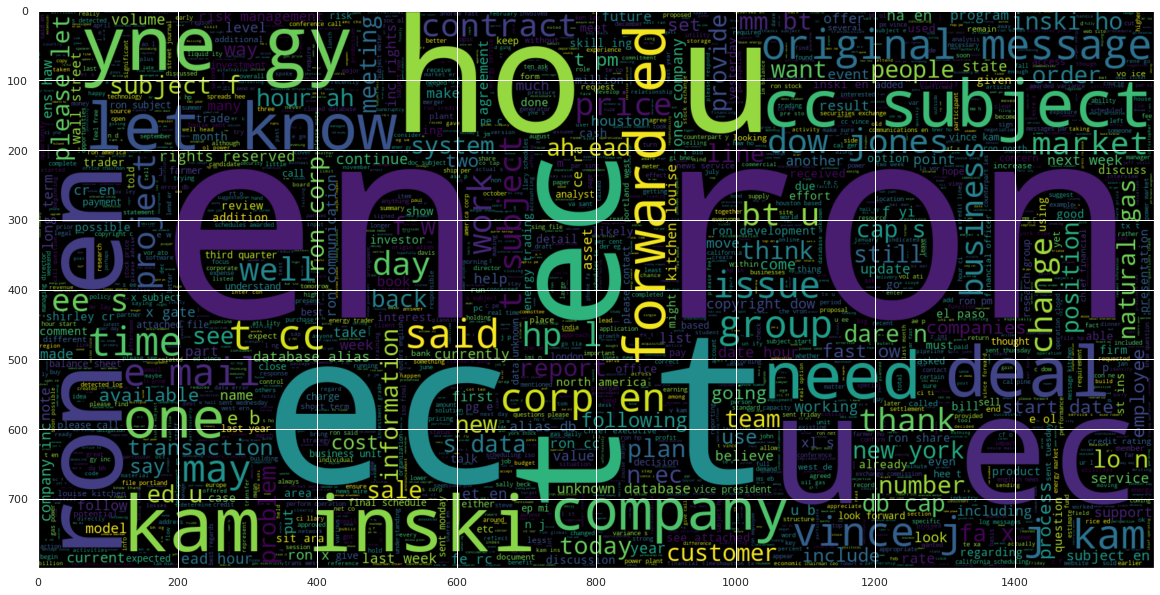

In [91]:
not_spam_words = []
for item in train[train.y == 0]['word_list']:
    not_spam_words += item
not_spam_words = ' '.join(not_spam_words)
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(not_spam_words)
plt.imshow(wc, interpolation="bilinear")

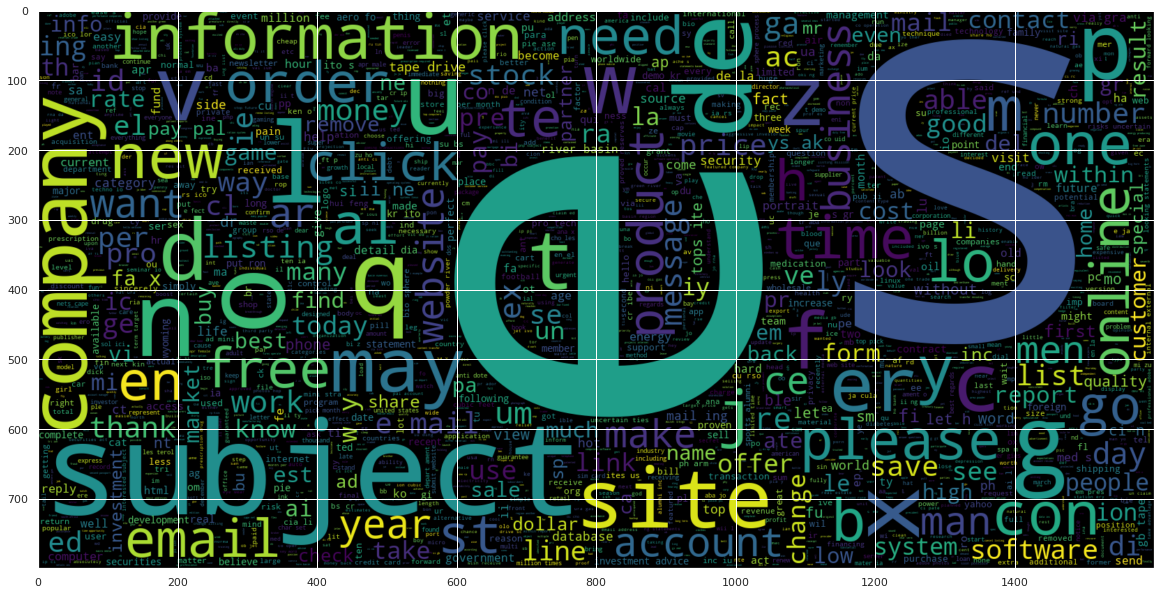

In [92]:
spam_words = []
for item in train[train.y == 1]['word_list']:
    spam_words += item
spam_words = ' '.join(spam_words)
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(spam_words)
plt.imshow(wc, interpolation="bilinear")